In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import extractor_sd as extractor_sd
from extractor_sd import load_model, process_features_and_mask, get_mask
from utils.utils_correspondence import co_pca, resize, find_nearest_patchs, find_nearest_patchs_replace, animate_image_transfer_reverse
import matplotlib.pyplot as plt
from extractor_dino import ViTExtractor

/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MASK = True
VER = "v1-5"
PCA = False
CO_PCA = True
PCA_DIMS = [256, 256, 256]
SIZE =960
RESOLUTION = 256
EDGE_PAD = False

FUSE_DINO = 1
ONLY_DINO = 0
DRAW_GIF=1
DINOV2 = True
MODEL_SIZE = 'base' # 'small' or 'base', indicate dinov2 model
DRAW_DENSE = 1
DRAW_SWAP = 1
SWAP = 1
TEXT_INPUT = False
SEED = 42
TIMESTEP = 100 #flexible from 0~200

DIST = 'l2' if FUSE_DINO and not ONLY_DINO else 'cos'
if ONLY_DINO:
    FUSE_DINO = True

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

model, aug = load_model(diffusion_ver=VER, image_size=SIZE, num_timesteps=TIMESTEP)

LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

The checkpoint state_dict contains keys that are not used by the model:
  model_ema.{decay, num_updates}
backbone.feature_extractor.,category_head.clip.clip.,clip_head.clip.clip.


In [4]:
def compute_pair_feature(model, aug, save_path, files, category, mask=False, dist='cos', real_size=960):
    if type(category) == str:
        category = [category]
    img_size = 840 if DINOV2 else 244
    model_dict={'small':'dinov2_vits14',
                'base':'dinov2_vitb14',
                'large':'dinov2_vitl14',
                'giant':'dinov2_vitg14'}
    
    model_type = model_dict[MODEL_SIZE] if DINOV2 else 'dino_vits8'
    layer = 11 if DINOV2 else 9
    if 'l' in model_type:
        layer = 23
    elif 'g' in model_type:
        layer = 39
    facet = 'token' if DINOV2 else 'key'
    stride = 14 if DINOV2 else 4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # indiactor = 'v2' if DINOV2 else 'v1'
    # model_size = model_type.split('vit')[-1]
    extractor = ViTExtractor(model_type, stride, device=device)
    patch_size = extractor.model.patch_embed.patch_size[0] if DINOV2 else extractor.model.patch_embed.patch_size
    num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)
    
    input_text = "a photo of "+category[-1][0] if TEXT_INPUT else None

    N = len(files) // 2
    pbar = tqdm(total=N)
    result = []
    for pair_idx in range(N):

        # Load image 1
        img1 = Image.open(files[2*pair_idx]).convert('RGB')
        img1_input = resize(img1, real_size, resize=True, to_pil=True, edge=EDGE_PAD)
        img1 = resize(img1, img_size, resize=True, to_pil=True, edge=EDGE_PAD)

        # Load image 2
        img2 = Image.open(files[2*pair_idx+1]).convert('RGB')
        img2_input = resize(img2, real_size, resize=True, to_pil=True, edge=EDGE_PAD)
        img2 = resize(img2, img_size, resize=True, to_pil=True, edge=EDGE_PAD)

        with torch.no_grad():
            if not CO_PCA:
                if not ONLY_DINO:
                    img1_desc = process_features_and_mask(model, aug, img1_input, input_text=input_text, mask=False, pca=PCA).reshape(1,1,-1, num_patches**2).permute(0,1,3,2)
                    img2_desc = process_features_and_mask(model, aug, img2_input, category[-1], input_text=input_text,  mask=mask, pca=PCA).reshape(1,1,-1, num_patches**2).permute(0,1,3,2)
                if FUSE_DINO:
                    img1_batch = extractor.preprocess_pil(img1)
                    img1_desc_dino = extractor.extract_descriptors(img1_batch.to(device), layer, facet)
                    img2_batch = extractor.preprocess_pil(img2)
                    img2_desc_dino = extractor.extract_descriptors(img2_batch.to(device), layer, facet)

            else:
                if not ONLY_DINO:
                    features1 = process_features_and_mask(model, aug, img1_input, input_text=input_text,  mask=False, raw=True)
                    features2 = process_features_and_mask(model, aug, img2_input, input_text=input_text,  mask=False, raw=True)
                    processed_features1, processed_features2 = co_pca(features1, features2, PCA_DIMS)
                    img1_desc = processed_features1.reshape(1, 1, -1, num_patches**2).permute(0,1,3,2)
                    img2_desc = processed_features2.reshape(1, 1, -1, num_patches**2).permute(0,1,3,2)
                if FUSE_DINO:
                    img1_batch = extractor.preprocess_pil(img1)
                    img1_desc_dino = extractor.extract_descriptors(img1_batch.to(device), layer, facet)
                    img2_batch = extractor.preprocess_pil(img2)
                    img2_desc_dino = extractor.extract_descriptors(img2_batch.to(device), layer, facet)
                
            if dist == 'l1' or dist == 'l2':
                # normalize the features
                img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                if FUSE_DINO:
                    img1_desc_dino = img1_desc_dino / img1_desc_dino.norm(dim=-1, keepdim=True)
                    img2_desc_dino = img2_desc_dino / img2_desc_dino.norm(dim=-1, keepdim=True)

            if FUSE_DINO and not ONLY_DINO:
                # cat two features together
                img1_desc = torch.cat((img1_desc, img1_desc_dino), dim=-1)
                img2_desc = torch.cat((img2_desc, img2_desc_dino), dim=-1)

            if ONLY_DINO:
                img1_desc = img1_desc_dino
                img2_desc = img2_desc_dino

            if DRAW_DENSE:
                mask1 = get_mask(model, aug, img1, category[0])
                mask2 = get_mask(model, aug, img2, category[-1])

                if ONLY_DINO or not FUSE_DINO:
                    img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                    img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                
                img1_desc_reshaped = img1_desc.permute(0,1,3,2).reshape(-1, img1_desc.shape[-1], num_patches, num_patches)
                img2_desc_reshaped = img2_desc.permute(0,1,3,2).reshape(-1, img2_desc.shape[-1], num_patches, num_patches)
                trg_dense_output, src_color_map = find_nearest_patchs(mask2, mask1, img2, img1, img2_desc_reshaped, img1_desc_reshaped, mask=mask)

                if not os.path.exists(f'{save_path}/{category[0]}'):
                    os.makedirs(f'{save_path}/{category[0]}')
                fig_colormap, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                ax1.axis('off')
                ax2.axis('off')
                ax1.imshow(src_color_map)
                ax2.imshow(trg_dense_output)
                fig_colormap.savefig(f'{save_path}/{category[0]}/{pair_idx}_colormap.png')
                plt.close(fig_colormap)
            
            if DRAW_SWAP:
                if not DRAW_DENSE:
                    mask1 = get_mask(model, aug, img1, category[0])
                    mask2 = get_mask(model, aug, img2, category[-1])

                if (ONLY_DINO or not FUSE_DINO) and not DRAW_DENSE:
                    img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                    img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                    
                img1_desc_reshaped = img1_desc.permute(0,1,3,2).reshape(-1, img1_desc.shape[-1], num_patches, num_patches)
                img2_desc_reshaped = img2_desc.permute(0,1,3,2).reshape(-1, img2_desc.shape[-1], num_patches, num_patches)
                trg_dense_output, src_color_map = find_nearest_patchs_replace(mask2, mask1, img2, img1, img2_desc_reshaped, img1_desc_reshaped, mask=mask, resolution=156)

                if not os.path.exists(f'{save_path}/{category[0]}'):
                    os.makedirs(f'{save_path}/{category[0]}')
                fig_colormap, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                ax1.axis('off')
                ax2.axis('off')
                ax1.imshow(src_color_map)
                ax2.imshow(trg_dense_output)
                fig_colormap.savefig(f'{save_path}/{category[0]}/{pair_idx}_swap.png')
                plt.close(fig_colormap)
            if not DRAW_SWAP and not DRAW_DENSE:
                result.append([img1_desc.cpu(), img2_desc.cpu()])
            else:
                result.append([img1_desc.cpu(), img2_desc.cpu(), mask1.cpu(), mask2.cpu()])

    pbar.update(1)
    return result

In [5]:
def process_images(src_img_path,trg_img_path,categories):

    files = [src_img_path, trg_img_path]
    save_path = './results_swap' + f'/{trg_img_path.split("/")[-1].split(".")[0]}_{src_img_path.split("/")[-1].split(".")[0]}'

    result = compute_pair_feature(model, aug, save_path, files, mask=MASK, category=categories, dist=DIST)
    
    if SWAP:
        # high resolution swap, will take the instance of interest from the target image and replace it in the source image
        for (feature2,feature1,mask2,mask1) in result:
            src_feature_reshaped = feature1.squeeze().permute(1,0).reshape(1,-1,60,60).cuda()
            tgt_feature_reshaped = feature2.squeeze().permute(1,0).reshape(1,-1,60,60).cuda()
            src_img=Image.open(trg_img_path)
            tgt_img=Image.open(src_img_path)
            
            patch_size = RESOLUTION # the resolution of the output image, set to 256 could be faster
            
            src_img = resize(src_img, patch_size, resize=True, to_pil=False, edge=EDGE_PAD)
            tgt_img = resize(tgt_img, patch_size, resize=True, to_pil=False, edge=EDGE_PAD)
            resized_src_mask = F.interpolate(mask1.unsqueeze(0).unsqueeze(0), size=(patch_size, patch_size), mode='nearest').squeeze().cuda()
            resized_tgt_mask = F.interpolate(mask2.unsqueeze(0).unsqueeze(0), size=(patch_size, patch_size), mode='nearest').squeeze().cuda()
            src_feature_upsampled = F.interpolate(src_feature_reshaped, size=(patch_size, patch_size), mode='bilinear').squeeze()
            tgt_feature_upsampled = F.interpolate(tgt_feature_reshaped, size=(patch_size, patch_size), mode='bilinear').squeeze()
            # mask the feature
            src_feature_upsampled = src_feature_upsampled * resized_src_mask.repeat(src_feature_upsampled.shape[0],1,1)
            tgt_feature_upsampled = tgt_feature_upsampled * resized_tgt_mask.repeat(src_feature_upsampled.shape[0],1,1)
            # Set the masked area to a very small number
            src_feature_upsampled[src_feature_upsampled == 0] = -100000
            tgt_feature_upsampled[tgt_feature_upsampled == 0] = -100000
            # Calculate the cosine similarity between src_feature and tgt_feature
            src_features_2d=src_feature_upsampled.reshape(src_feature_upsampled.shape[0],-1).permute(1,0)
            tgt_features_2d=tgt_feature_upsampled.reshape(tgt_feature_upsampled.shape[0],-1).permute(1,0)
            swapped_image=src_img
            mapping = torch.zeros(patch_size,patch_size,2).cuda()
            for patch_idx in tqdm(range(patch_size*patch_size)):
                # If the patch is in the resized_src_mask_out_layers, find the corresponding patch in the target_output and swap them
                if resized_src_mask[patch_idx // patch_size, patch_idx % patch_size] == 1:
                    # Find the corresponding patch with the highest cosine similarity
                    distances = torch.linalg.norm(tgt_features_2d - src_features_2d[patch_idx], dim=1)
                    tgt_patch_idx = torch.argmin(distances)

                    tgt_patch_row = tgt_patch_idx // patch_size
                    tgt_patch_col = tgt_patch_idx % patch_size

                    # Swap the patches in output
                    swapped_image[patch_idx // patch_size, patch_idx % patch_size,:] = tgt_img[tgt_patch_row, tgt_patch_col,:]
                    mapping[patch_idx // patch_size, patch_idx % patch_size] = torch.tensor([tgt_patch_row,tgt_patch_col])
        #save the swapped image
        swapped_image=Image.fromarray(swapped_image)
        swapped_image.save(save_path+'/swapped_image.png')
        if DRAW_GIF:
            animate_image_transfer_reverse(resize(Image.open(trg_img_path), patch_size, resize=True, to_pil=True, edge=EDGE_PAD),resize(Image.open(src_img_path), patch_size, resize=True, to_pil=True, edge=EDGE_PAD),mapping,save_path+'/warp_pixel.gif')
        
    return result

Using cache found in /home/junyi/.cache/torch/hub/facebookresearch_dinov2_main
  0%|          | 0/1 [00:00<?, ?it/s]/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 65536/65536 [00:32<00:00, 2016.76it/s] 
Using cache found in /home/junyi/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 65536/65536 [00:32<00:00, 2016.76it/s] 
Using cache found in /home/junyi/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 65536/65536 [00:32<00:00, 2027.53it/s] 


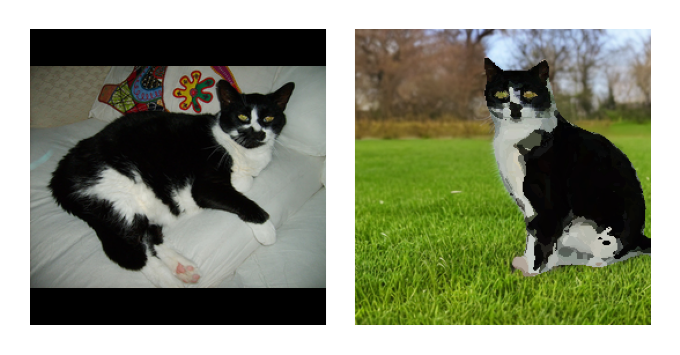

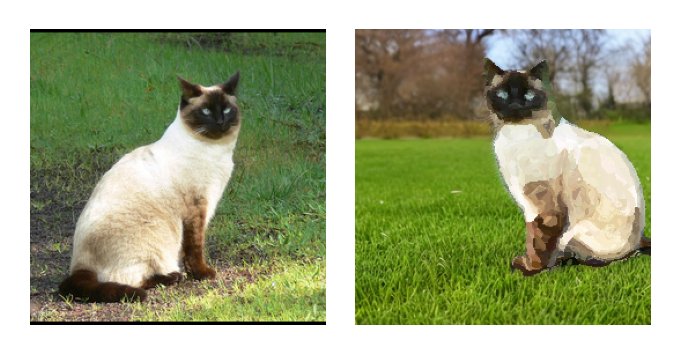

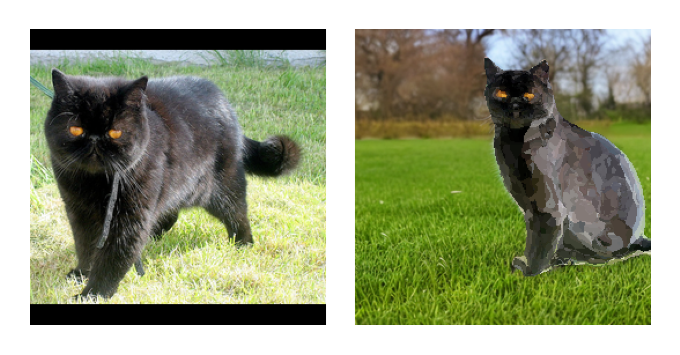

In [6]:
src_paths=[
            "data/images/cat1.jpg",
            "data/images/cat2.jpg",
            "data/images/cat3.jpg",
           ]
SWAP=1
DRAW_GIF=1
RESOLUTION = 256 # resolution for swapped images, set to 512 to align with the paper
for src_path in src_paths:
    src_img_path = src_path
    trg_img_path = "data/images/cat0.jpg"
    categories = [['cat'], ['cat']]
    result = process_images(src_img_path, trg_img_path, categories)